In [1]:
from iotbx.map_manager import map_manager as MapManager
from mmtbx.model import manager as ModelManager
from iotbx.data_manager import DataManager
from iotbx.map_model_manager import map_model_manager as MapModelManager
from mmtbx.maps.correlation import five_cc

In [2]:
import os
import pickle
from multiprocessing import Pool
from collections import Counter
import numpy as np
import gzip
import shutil

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use("seaborn-notebook")
plot_scale = 0.75
font_scale = 2

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (16*plot_scale, 11*plot_scale),
         'axes.labelsize': 10*font_scale,
         'axes.titlesize':10*font_scale,
         'xtick.labelsize':10*font_scale,
         'ytick.labelsize':10*font_scale}
plt.rcParams.update(params)

In [4]:
nucleotide_entries_path = "data/nucleotide_entries.pkl" # list of entries
working_directory = "../../maps_and_models_ligand_extracted" # directory of extracted densities and ligand models

In [5]:
entry_ids = os.listdir(working_directory)

with open(nucleotide_entries_path,"rb") as fh:
    nucleotide_entries = pickle.load(fh)


In [6]:
len(entry_ids)

83

In [7]:
resolutions = np.array([entry.resolution for entry in nucleotide_entries if (entry.entry in entry_ids) and (entry.resolution is not None)])

Text(0.5,0,'Resolution estimate (angstroms)')

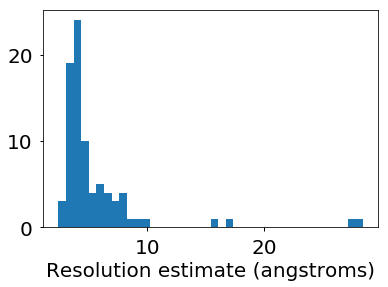

In [8]:
ret = plt.hist(resolutions,bins=40)
#plt.xlim(0,15)
plt.xlabel("Resolution estimate (angstroms)")

In [9]:
low_res_entries_dict = {entry.entry:entry for entry in nucleotide_entries if (entry.entry in entry_ids) and (entry.resolution is not None) and (entry.resolution <=10)}

In [10]:
# filter out poor resolution or non-existent resolution entries
nucleotide_entries_dict = {entry.entry:entry for entry in nucleotide_entries if (entry.entry in entry_ids) and (entry.resolution is not None) and (entry.resolution <=10)}


In [11]:
len(nucleotide_entries_dict)

79

In [12]:
# open all maps and models, calculate cross correlation
five_cc_obj_dict = {}
for entry_id in nucleotide_entries_dict.keys():
    entry = nucleotide_entries_dict[entry_id]
    entry_directory = working_directory+"/"+entry_id
    contents = os.listdir(entry_directory)
    ligand_ids = list(set([f.split(".")[0] for f in contents if "ligand" in f]))
    
    for ligand_id in ligand_ids:
        ligand_map_path = entry_directory+"/"+ligand_id+".map"
        ligand_model_path = entry_directory+"/"+ligand_id+".pdb"
        dm = DataManager()
        dm.process_model_file(ligand_model_path)
        model_manager = dm.get_model()
        map_manager = MapManager(ligand_map_path)
        mmm = MapModelManager(map_manager=map_manager, model=model_manager)

        d_min = entry.resolution
        five_cc_obj = five_cc(
                       mmm.map_data(),
                       mmm.model().get_xray_structure(),
                       d_min,
                       box=None,
                       keep_map_calc=False,
                       compute_cc_box=False,
                       compute_cc_image=False,
                       compute_cc_mask=True,
                       compute_cc_volume=True,
                       compute_cc_peaks=True)

        five_cc_obj_dict[entry_id+"_"+ligand_id] = five_cc_obj

    

In [13]:
from collections import OrderedDict
import operator

In [14]:
# extract the cc_mask value to an array
cc_mask_dict = {}

for i,(key,value) in enumerate(five_cc_obj_dict.items()):
    cc_mask = value.result()["cc_mask"]
    cc_mask_dict[key]=cc_mask
    
cc_mask_dict = OrderedDict(sorted(cc_mask_dict.items(), key=operator.itemgetter(1),reverse=True))

## Plot

Text(0.5,0,'CCmask')

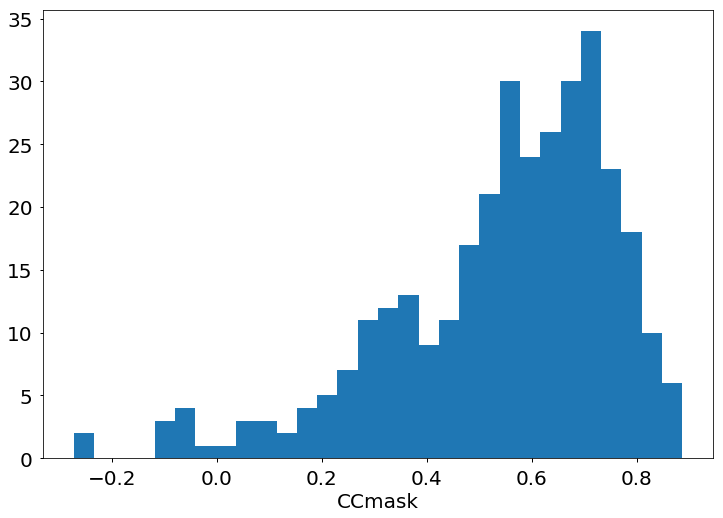

In [18]:
cc_mask_array = np.array(cc_mask_dict.values())
n,bins,patches = plt.hist(cc_mask_array,bins=30)
plt.xlabel("CCmask")

In [25]:
len(cc_mask_array)

330

In [19]:
def find_nearest(array, value,retidx=True):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    if retidx:
        return idx
    else:
        return array[idx]
cc_mask_values = np.array(cc_mask_dict.values())

In [20]:
# find some examples
best_cc_key = cc_mask_dict.keys()[find_nearest(cc_mask_values,1)]
worst_cc_key = cc_mask_dict.keys()[find_nearest(cc_mask_values,-1)]
zero_cc_key = cc_mask_dict.keys()[find_nearest(cc_mask_values,0)]
half_cc_key = cc_mask_dict.keys()[find_nearest(cc_mask_values,0.5)]

In [21]:
best_cc_key = "6f1u_4169_ligand_ADP_B"

In [27]:
print("CC=best:",best_cc_key,cc_mask_dict[best_cc_key])
print("CC=half:",half_cc_key,cc_mask_dict[half_cc_key])
print("CC=zero",zero_cc_key,cc_mask_dict[zero_cc_key])
print("CC=worst:",worst_cc_key,cc_mask_dict[worst_cc_key])


('CC=best:', '6f1u_4169_ligand_ADP_B', 0.8403064511105527)
('CC=half:', '6oif_20076_ligand_ATP_R', 0.5006414363130907)
('CC=zero', '6qi8_4552_ligand_ADP_C', 0.010055861468697027)
('CC=worst:', '6pto_20473_ligand_ATP_5', -0.2725449354783971)


In [30]:
nucleotide_entries_dict["6pto_20473"]

group_args
  _stop_dynamic_attributes__enabled : True
  composition                    : <mmtbx.model.statistics.composition object at 0x7f9d62f48510>
  date                           : 2019-07-16
  entry                          : 6pto_20473
  entry_emdb                     : 20473
  entry_pdb                      : 6pto
  error                          : None
  map_file                       : /net/cci-filer2/raid1/emdb_mirror/structures/EMD-20473/map/emd_20473.map.gz
  map_file_1                     : None
  map_file_2                     : None
  model_file                     : /net/cci/pdb_mirror/mmcif/pt/6pto.cif.gz
  resolution                     : 7.0

In [123]:
cc_ordered_entry_ids = []
for entry in cc_mask_dict.keys():
    split = entry.split("_")
    entry_id = split[0]+"_"+split[1]
    cc_ordered_entry_ids.append(entry_id)

In [125]:
resolutions = np.array([nucleotide_entries_dict[entry_id].resolution for entry_id in cc_ordered_entry_ids])

Text(0.5,0,'CCmask')

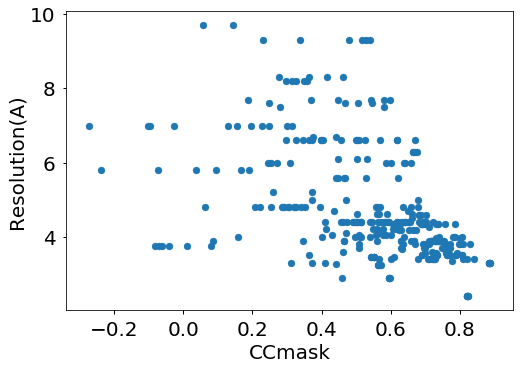

In [129]:
plt.scatter(cc_mask_dict.values(),resolutions)
plt.ylabel("Resolution(A)")
plt.xlabel("CCmask")